### Reconstruction of EDJ metrics with causal maps evaluated from reanalysis data

#### Functions and imports

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature
import statsmodels.api as sm
from scipy import signal
import random
import matplotlib.gridspec as gridspec
from scipy.signal import detrend
import urllib.request
from statsmodels.graphics.tsaplots import plot_acf

In [8]:
### Functions

def regressor_EESC_GW(gw_ts):
    eesc_ts = pd.read_csv('/home/jmindlin/causal_EDJ/send_to_LIM/GW_EESC_polar_ozoneloss.csv')
    for i in range(len(eesc_ts[:8])):
        eesc_ts['EESC_polar'][i] = eesc_ts['EESC_polar'][8]
    df = pd.DataFrame({'EESC':eesc_ts['EESC_polar'][10:79] - eesc_ts['EESC_polar'][8],'GW':gw_ts})
    regressors_out = sm.add_constant(df.values)
    return regressors_out, df

def stand_detr(dato):
    anom = (dato - np.mean(dato))/np.std(dato)
    return signal.detrend(anom)

def filtro(dato):
    """Apply a rolling mean of 5 years and remov the NaNs resulting bigining and end"""
    signal = dato - dato.rolling(time=10, center=True).mean()
    signal_out = signal.dropna('time', how='all')
    return signal_out
                          
def stand(dato):
    anom = (dato - np.mean(dato))/np.std(dato)
    return anom

def replace_nans_with_zero(x):
    return np.where(np.isnan(x), random.random(), x)

def figure(target,predictors):
    fig = plt.figure()
    y = predictors.apply(stand_detr,axis=0).values
    for i in range(len(predictors.keys())):
        plt.plot(y[:,i])
    plt.plot(stand_detr(target))
    return fig

def jet_lat_strength(jet_data,lon1=-180,lon2=180):
    if np.max(jet_data.lon.values) > 300:
        ds = jet_data.assign_coords(lon=((jet_data.lon + 180) % 360) - 180)
        ds = ds.sortby("lon")
        jet_data = ds
    else:
        jet_data = jet_data
    jet_30_70 = jet_data.sel(lat=slice(-30,-70)).sel(lon=slice(lon1,lon2)).mean(dim='lon')
    lat = jet_30_70.lat
    jet_lat = (jet_30_70*lat).sum(dim='lat')/(jet_30_70).sum(dim='lat')
    strength = []
    for t,max_lat in zip(jet_data.time,jet_lat):
        strength.append(jet_data.sel(time=t).sel(lat=max_lat,method='nearest').sel(lon=slice(lon1,lon2)).mean(dim='lon'))
    jet_strength = np.array(strength)
    return np.array(jet_lat.values),jet_strength

def jet_lat_strength_model(jet_data,lon1=-180,lon2=180):
    if np.max(jet_data.lon.values) > 300:
        ds = jet_data.assign_coords(lon=((jet_data.lon + 180) % 360) - 180)
        ds = ds.sortby("lon")
        jet_data = ds
    else:
        jet_data = jet_data
    jet_30_70 = jet_data.sel(lat=slice(-70,-30)).sel(lon=slice(lon1,lon2)).mean(dim='lon')
    lat = jet_30_70.lat
    jet_lat = (jet_30_70*lat).sum(dim='lat')/(jet_30_70).sum(dim='lat')
    strength = []
    for t,max_lat in zip(jet_data.time,jet_lat):
        strength.append(jet_data.sel(time=t).sel(lat=max_lat,method='nearest').sel(lon=slice(lon1,lon2)).mean(dim='lon'))
    jet_strength = np.array(strength)
    return np.array(jet_lat.values),jet_strength

def seasonal_data(data,season='DJF'):
    # select DJF
    DA_DJF = data.sel(time = data.time.dt.season==season)

    # calculate mean per year
    DA_DJF = DA_DJF.groupby(DA_DJF.time.dt.year).mean("time")
    DA_DJF = DA_DJF.rename({'year':'time'})
    return DA_DJF

def seasonal_data_months(data, months):
    """
    Selects specified months from an xarray object and averages the data for those months within each year.
    
    Parameters:
    - data: xarray.DataArray or xarray.Dataset
        The input data to process. It should have a 'time' coordinate.
    - months: list of int
        The months to select for averaging (1 = January, 2 = February, ..., 12 = December).
    
    Returns:
    - xarray.DataArray or xarray.Dataset
        The averaged data for the selected months within each year, accounting for months that span across years.
    """
    # Ensure 'time' coordinate is in a format that supports .dt accessor
    if np.issubdtype(data['time'].dtype, np.datetime64):
        time_coord = data['time']
    else:
        time_coord = xr.cftime_range(start=data['time'][0].values, periods=data['time'].size, freq='M')
        data = data.assign_coords(time=time_coord)

    # Select the relevant months and keep track of the original years
    selected_months_data = data.sel(time=data['time'].dt.month.isin(months))

    # Create a new time coordinate for grouping
    new_years = selected_months_data['time'].dt.year.values.copy()

    # Shift the year for December, if necessary
    if 12 in months:
        dec_mask = selected_months_data['time'].dt.month == 12
        new_years[dec_mask] += 1  # Increment year for December

    # Assign the new year as a coordinate to the selected data
    selected_months_data = selected_months_data.assign_coords(new_year=("time", new_years))

    # Now group by the new year and calculate the mean
    averaged_data = selected_months_data.groupby("new_year").mean(dim="time")

    # Rename the new year dimension to 'time' for consistency
    averaged_data = averaged_data.rename({"new_year": "time"})

    return averaged_data


#Across models regression class
class spatial_MLR(object):
    def __init__(self):
        self.what_is_this = 'This performs a regression across models and plots everything'
    
    def regression_data(self,variable,regressors,regressor_names,dataset):
        """Define the regression target variable 
        this is here to be edited if some opperation is needed on the DataArray
        
        :param variable: DataArray
        :return: target variable for the regression  
        """
        self.dataset = dataset
        self.target = variable
        regressor_indices = regressors
        self.regression_y = sm.add_constant(regressors.values)
        self.regressors = regressors.values
        self.rd_num = len(regressor_names) 
        self.regressor_names = regressor_names

    #Regresion lineal
    def linear_regression(self,x):
        y = self.regression_y
        res = sm.OLS(x,y).fit()
        returns = [res.params[i] for i in range(self.rd_num)]
        return tuple(returns)

    def linear_regression_pvalues(self,x):
        y = self.regression_y
        res = sm.OLS(x,y).fit()
        returns = [res.pvalues[i] for i in range(self.rd_num)]
        return tuple(returns)
    
    def linear_regression_R2(self,x):
        y = self.regression_y
        res = sm.OLS(x,y).fit()
        return res.rsquared
    

    def perform_regression(self,path,var): 
        """ Performs regression over all gridpoints in a map and returns and saves DataFrames
        
        :param path: saving path
        :return: none
        """
        
        target_var = xr.apply_ufunc(replace_nans_with_zero, self.target)
        results = xr.apply_ufunc(self.linear_regression,target_var,input_core_dims=[["time"]],
                                 output_core_dims=[[] for i in range(self.rd_num)],
                                 vectorize=True,
                                 dask="parallelized")
        results_pvalues = xr.apply_ufunc(self.linear_regression_pvalues,target_var,input_core_dims=[["time"]],
                                 output_core_dims=[[] for i in range(self.rd_num)],
                                 vectorize=True,
                                 dask="parallelized")
        results_R2 = xr.apply_ufunc(self.linear_regression_R2,target_var,input_core_dims=[["time"]],
                                 output_core_dims=[[]],
                                 vectorize=True,
                                 dask="parallelized")
        
      
        for i in range(self.rd_num):
            if i == 0:
                regression_coefs = results[0].to_dataset(name='const')
            else:
                regression_coefs[self.regressor_names[i]] = results[i]
                
        print('This is regressor_coefs:',regression_coefs)
        if var == 'ua':
            regression_coefs = regression_coefs.rename({'ua':self.regressor_names[0]})
        elif var == 'sst':
            regression_coefs = regression_coefs.rename({'tos':self.regressor_names[0]})
        elif var == 'tas':
            regression_coefs = regression_coefs.rename({'tas':self.regressor_names[0]})
        elif var == 'pr':
            regression_coefs = regression_coefs.rename({'pr':self.regressor_names[0]})
        else:
            'done'
            #regression_coefs = regression_coefs.rename({var:self.regressor_names[0]})
        regression_coefs.to_netcdf(path+'/'+var+'/regression_coefficients_'+self.dataset+'.nc')
        
        for i in range(self.rd_num):
            if i == 0:
                regression_coefs_pvalues = results_pvalues[0].to_dataset(name='const')
            else:
                regression_coefs_pvalues[self.regressor_names[i]] = results_pvalues[i]        
        if var == 'ua':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'ua':self.regressor_names[0]})
        elif var == 'sst':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'tos':self.regressor_names[0]})
        elif var == 'tas':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'tas':self.regressor_names[0]})
        elif var == 'pr':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'pr':self.regressor_names[0]})
        else:
            'done'
            #regression_coefs_pvalues = regression_coefs_pvalues.rename({var:self.regressor_names[0]})
        regression_coefs_pvalues.to_netcdf(path+'/'+var+'/regression_coefficients_pvalues_'+self.dataset+'.nc')
        

        results_R2.to_netcdf(path+'/'+var+'/R2_'+self.dataset+'.nc')
                     
        
    def create_x(self,i,j,dato):
        """ For each gridpoint creates an array and standardizes it 
        :param regressor_names: list with strings naming the independent variables
        :param path: saving path
        :return: none
        """    
        x = np.array([])
        for y in range(len(dato.time)):
            aux = dato.isel(time=y)
            x = np.append(x,aux[i-1,j-1].values)
        return stand(x)
     
    
    def open_regression_coef(self,path,var,dataset):
        """ Open regression coefficients and pvalues to plot
        :param path: saving path
        :return maps: list of list of coefficient maps
        :return maps_pval:  list of coefficient pvalues maps
        :return R2: map of fraction of variance
        """ 
        maps = []; maps_pval = []
        coef_maps = xr.open_dataset(path+'/'+var+'/regression_coefficients_'+dataset+'.nc')
        coef_pvalues = xr.open_dataset(path+'/'+var+'/regression_coefficients_pvalues_'+dataset+'.nc')
        maps = [coef_maps[variable] for variable in self.regressor_names]
        maps_pval = [coef_pvalues[variable] for variable in self.regressor_names]
        R2 = xr.open_dataset(path+'/'+var+'/R2_'+dataset+'.nc')
        return maps, maps_pval, R2    

    def open_lmg_coef(self,path,var):
        """ Open regression coefficients and pvalues to plot
        :param path: saving path
        :return maps: list of list of coefficient maps
        :return maps_pval:  list of coefficient pvalues maps
        :return R2: map of fraction of variance
        """ 
        maps = []; maps_pval = []
        coef_maps = xr.open_dataset(path+'/'+var+'/regression_coefficients_relative_importance.nc')
        coef_pvalues = xr.open_dataset(path+'/'+var+'/regression_coefficients_pvalues.nc')
        maps = [coef_maps[variable] for variable in self.regressor_names[1:]]
        maps_pval = [coef_pvalues[variable] for variable in self.regressor_names]
        R2 = xr.open_dataset(path+'/'+var+'/R2.nc')
        return maps, maps_pval, R2    
    
    def plot_regression_lmg_map(self,path,var,output_path):
        """ Plots figure with all of 
        :param regressor_names: list with strings naming the independent variables
        :param path: saving path
        :return: none
        """
        maps, maps_pval, R2 = self.open_lmg_coef(path,var)
        cmapU850 = mpl.colors.ListedColormap(['darkblue','navy','steelblue','lightblue',
                                            'lightsteelblue','white','white','mistyrose',
                                            'lightcoral','indianred','brown','firebrick'])
        cmapU850.set_over('maroon')
        cmapU850.set_under('midnightblue')
        path_era = '/datos/ERA5/mon'
        u_ERA = xr.open_dataset(path_era+'/era5.mon.mean.nc')
        u_ERA = u_ERA.u.sel(lev=850).sel(time=slice('1979','2018'))
        u_ERA = u_ERA.groupby('time.season').mean(dim='time').sel(season='DJF')

        fig_coef = plt.figure(figsize=(20, 16),dpi=100,constrained_layout=True)
        projection_stereo = ccrs.SouthPolarStereo(central_longitude=300)
        projection_plate = ccrs.PlateCarree(180)
        data_crs = ccrs.PlateCarree()
        for k in range(self.rd_num-1):
            lat = maps[k].lat
            lon = np.linspace(0,360,len(maps[k].lon))
            var_c, lon_c = add_cyclic_point(maps[k].values,lon)
            #SoutherHemisphere Stereographic
            if var == 'ua':
                ax = plt.subplot(3,3,k+1,projection=projection_stereo)
                ax.set_extent([0,359.9, -90, 0], crs=data_crs)
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)
                ax.set_boundary(circle, transform=ax.transAxes)
            elif var == 'sst':
                ax = plt.subplot(3,3,k+1,projection=projection_plate)
            else: 
                ax = plt.subplot(3,3,k+1,projection=projection_stereo)
            clevels = np.arange(0,40,2)
            im=ax.contourf(lon_c, lat, var_c*100,clevels,transform=data_crs,cmap='OrRd',extend='both')
            cnt=ax.contour(u_ERA.lon,u_ERA.lat, u_ERA.values,levels=[8],transform=data_crs,linewidths=1.2, colors='black', linestyles='-')
            plt.clabel(cnt,inline=True,fmt='%1.0f',fontsize=8)
            if maps_pval[k+1].min() < 0.05: 
                levels = [maps_pval[k+1].min(),0.05,maps_pval[k+1].max()]
                ax.contourf(maps_pval[k+1].lon, lat, maps_pval[k+1].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            elif maps_pval[k+1].min() < 0.10:
                levels = [maps_pval[k+1].min(),0.10,maps_pval[k+1].max()]
                ax.contourf(maps_pval[k+1].lon, lat, maps_pval[k+1].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            else:
                print('No significant values for ',self.regressor_names[k+1]) 
            plt.title(self.regressor_names[k+1],fontsize=18)
            ax.add_feature(cartopy.feature.COASTLINE,alpha=.5)
            ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
            ax.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
            ax.set_extent([-180, 180, -90, -25], ccrs.PlateCarree())
        plt1_ax = plt.gca()
        left, bottom, width, height = plt1_ax.get_position().bounds
        if var == 'ua':
            colorbar_axes1 = fig_coef.add_axes([left+0.5, bottom, 0.01, height*2])
        elif var == 'sst':
            colorbar_axes1 = fig_coef.add_axes([left+0.3, bottom, 0.01, height*2])    
        else:
            colorbar_axes1 = fig_coef.add_axes([left+0.5, bottom, 0.01, height*2])
        cbar = fig_coef.colorbar(im, colorbar_axes1, orientation='vertical')
        cbar.set_label('relative importance',fontsize=14) #rotation = radianes
        cbar.ax.tick_params(axis='both',labelsize=14)
            
        plt.subplots_adjust(bottom=0.2, right=.95, top=0.8)
        if var == 'ua':
            plt.savefig(output_path+'/regression_coefficients_relative_importance_u850',bbox_inches='tight')
        elif var == 'sst':
            plt.savefig(output_path+'/regression_coefficients_relative_importance_sst',bbox_inches='tight')
        else:
            plt.savefig(output_path+'/regression_coefficients_relative_importance_XXX',bbox_inches='tight')   
        plt.clf

        return fig_coef


    def plot_regression_coef_map(self,path,var,output_path):
        """ Plots figure with all of 
        :param regressor_names: list with strings naming the independent variables
        :param path: saving path
        :return: none
        """
        maps, maps_pval, R2 = self.open_regression_coef(path,var,self.dataset)
        cmapU850 = mpl.colors.ListedColormap(['darkblue','navy','steelblue','lightblue',
                                            'lightsteelblue','white','white','mistyrose',
                                            'lightcoral','indianred','brown','firebrick'])
        cmapU850.set_over('maroon')
        cmapU850.set_under('midnightblue')
        u_ERA = xr.open_dataset('/home/jmindlin/causal_EDJ/ERA5/ua_ERA5.nc')
        u_ERA = u_ERA.u.sel(level=850).sel(time=slice('1979','2018'))
        u_ERA = u_ERA.rename({'longitude':'lon','latitude':'lat'})
        u_ERA = u_ERA.groupby('time.season').mean(dim='time').sel(season='DJF')

        fig_coef = plt.figure(figsize=(20, 16),dpi=100,constrained_layout=True)
        projection_stereo = ccrs.SouthPolarStereo(central_longitude=300)
        projection_plate = ccrs.PlateCarree(180)
        data_crs = ccrs.PlateCarree()
        for k in range(self.rd_num):
            lat = maps[k].lat
            lon = np.linspace(0,360,len(maps[k].lon))
            var_c, lon_c = add_cyclic_point(maps[k].values,lon)
            #SoutherHemisphere Stereographic for winds
            if var == 'u':
                ax = plt.subplot(3,2,k+1,projection=projection_stereo)
                ax.set_extent([0,359.9, -90, 0], crs=data_crs)
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)
                ax.set_boundary(circle, transform=ax.transAxes)
            #Plate Carree map for SST
            elif var == 'sst':
                ax = plt.subplot(3,2,k+1,projection=projection_plate)
            else: 
                ax = plt.subplot(3,2,k+1,projection=projection_stereo)
            if k == 6:
                im0=ax.contourf(lon_c, lat, var_c,transform=data_crs,cmap='OrRd',extend='both')
            else:
                clevels = np.arange(-.6,.7,0.1)
                im=ax.contourf(lon_c, lat, var_c,clevels,transform=data_crs,cmap='RdBu_r',extend='both')
            cnt=ax.contour(u_ERA.lon,u_ERA.lat, u_ERA.values,levels=[8],transform=data_crs,linewidths=1.2, colors='black', linestyles='-')
            plt.clabel(cnt,inline=True,fmt='%1.0f',fontsize=8)
            if maps_pval[k].min() < 0.05: 
                levels = [maps_pval[k].min(),0.05,maps_pval[k].max()]
                ax.contourf(maps_pval[k].lon, lat, maps_pval[k].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            elif maps_pval[k].min() < 0.10:
                levels = [maps_pval[k].min(),0.10,maps_pval[k].max()]
                ax.contourf(maps_pval[k].lon, lat, maps_pval[k].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            else:
                print('No significant values for ',self.regressor_names[k]) 
            plt.title(self.regressor_names[k],fontsize=18)
            ax.add_feature(cartopy.feature.COASTLINE,alpha=.5)
            ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
            ax.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
            if var == 'ua':
                ax.set_extent([-180, 180, -90, -25], ccrs.PlateCarree())
            elif var == 'sst':
                ax.set_extent([-60, 220, -80, 40], ccrs.PlateCarree(central_longitude=180))
            else: 
                ax.set_extent([-60, 220, -80, -25], ccrs.PlateCarree(central_longitude=180))
            
        plt1_ax = plt.gca()
        left, bottom, width, height = plt1_ax.get_position().bounds
        if var == 'ua':
            colorbar_axes1 = fig_coef.add_axes([left+0.28, bottom, 0.01, height*2])
            colorbar_axes2 = fig_coef.add_axes([left+0.36, bottom, 0.01, height*2])
        elif var == 'sst':
            colorbar_axes1 = fig_coef.add_axes([left+0.3, bottom, 0.01, height*3])
            colorbar_axes2 = fig_coef.add_axes([left+0.38, bottom, 0.01, height*3])
        else:
            colorbar_axes1 = fig_coef.add_axes([left+0.28, bottom, 0.01, height*2])
            colorbar_axes2 = fig_coef.add_axes([left+0.36, bottom, 0.01, height*2])
        cbar = fig_coef.colorbar(im, colorbar_axes1, orientation='vertical')
        cbar2 = fig_coef.colorbar(im, colorbar_axes2, orientation='vertical')
        if var == 'ua':
            cbar.set_label('m/s/std(rd)',fontsize=14) #rotation = radianes
            cbar2.set_label('m/s/std(rd)',fontsize=14) #rotation = radianes
        elif var == 'sst':
            cbar.set_label('K/std(rd)',fontsize=14) #rotation = radianes
            cbar2.set_label('K/std(rd)',fontsize=14) #rotation = radianes
        else:
            cbar.set_label('X/std(rd)',fontsize=14) #rotation = radianes
            cbar2.set_label('X/std(rd)',fontsize=14) #rotation = radianes
        cbar.ax.tick_params(axis='both',labelsize=14)
        cbar2.ax.tick_params(axis='both',labelsize=14)
            
        plt.subplots_adjust(bottom=0.2, right=.95, top=0.8)
        if var == 'ua':
            plt.savefig(output_path+'/regression_coefficients_u850',bbox_inches='tight')
        elif  var == 'sst':
            plt.savefig(output_path+'/regression_coefficients_sst',bbox_inches='tight')
        else:
            plt.savefig(output_path+'/regression_coefficients_unknown_var',bbox_inches='tight')
        
        plt.clf

        return fig_coef


def plot_regression_coef_map_MEM(maps, maps_pval, regressor_names, output_path):
    """Plots figure with regression coefficient maps with two distinct colorbars.
    :param regressor_names: list with strings naming the independent variables
    :param path: saving path
    :return: figure
    """

    # Custom colormap
    cmapU850 = mpl.colors.ListedColormap(['darkblue', 'navy', 'steelblue', 'lightblue',
                                'lightsteelblue', 'white', 'white', 'mistyrose',
                                'lightcoral', 'indianred', 'brown', 'firebrick'])
    cmapU850.set_over('maroon')
    cmapU850.set_under('midnightblue')

    # Load data for contours
    ua_era5 = xr.open_dataset('/home/jmindlin/causal_EDJ/ERA5/ua_ERA5.nc')
    ua_era5 = ua_era5.rename({'latitude': 'lat', 'longitude': 'lon'})
    ua_era5_850 = ua_era5.sel(level=850)
    u_ERA = ua_era5_850.u.sel(time=slice('1979', '2018'))
    u_ERA = u_ERA.groupby('time.season').mean(dim='time').sel(season='DJF')

    # Create figure and subplots with adjusted size
    fig_coef, axs = plt.subplots(2, 3, figsize=(24, 15), dpi=100,
                                subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=300)})
    plt.subplots_adjust(bottom=0.1, right=0.85, top=0.85, hspace=0.1, wspace=0.25)

    data_crs = ccrs.PlateCarree()

    # Loop over the subplots
    for k, ax in enumerate(axs.flat):
        if k >= len(maps):  # Stop if we have more subplots than data
            break
        
        lat = maps[k].lat
        lon = np.linspace(0, 360, len(maps[k].lon))
        var_c, lon_c = add_cyclic_point(maps[k].values, lon)

        ax.set_extent([0, 359.9, -90, 0], crs=data_crs)
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

        # Use different color scales for the first and other subplots
        if k == 0:
            clevels = np.arange(-11, 12, 1)
            # Contour plot
            im0 = ax.contourf(maps[k].lon, maps[k].lat, maps[k].values, clevels, transform=data_crs, cmap=cmapU850, extend='both')
        else:
            clevels = np.arange(-1, 1.1, 0.1)
            # Contour plot
            try:
                im = ax.contourf(maps[k].lon, maps[k].lat, maps[k].values, clevels, transform=data_crs, cmap=cmapU850, extend='both')
            except TypeError:
                print(maps[k])

        # Overlay contour lines for u_ERA
        cnt = ax.contour(u_ERA.lon, u_ERA.lat, u_ERA.values, levels=[8], transform=data_crs,
                        linewidths=1.2, colors='black', linestyles='-')
        ax.clabel(cnt, inline=True, fmt='%1.0f', fontsize=8)

        # Check for significant p-values and hatch regions
        if maps_pval[k].min() < 0.05:
            levels = [maps_pval[k].min(), 0.05, maps_pval[k].max()]
            ax.contourf(maps_pval[k].lon, lat, maps_pval[k].values, levels=levels,
                        transform=data_crs, hatches=["...", " "], alpha=0)
        
        # Plot title
        ax.set_title(regressor_names[k], fontsize=18)
        
        # Add coastlines and borders
        ax.add_feature(cartopy.feature.COASTLINE, alpha=.5)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
        ax.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
        ax.set_extent([-180, 180, -90, -25], ccrs.PlateCarree())

    # Create two colorbars outside the grid of subplots

    # Colorbar for the first subplot
    cbar_ax_1 = fig_coef.add_axes([0.87, 0.55, 0.02, 0.25])  # Manually specify position
    cbar_1 = fig_coef.colorbar(im0, cax=cbar_ax_1, orientation='vertical', ticks=np.arange(-11, 12, 1))
    cbar_1.set_label(r'm s$^{-1}$ $\sigma_{RD}^{-1}$', fontsize=14)
    cbar_1.ax.tick_params(axis='both', labelsize=12)

    # Add "panel a" text above the first colorbar
    plt.text(0.87, 0.82, 'panel a', fontsize=14, transform=fig_coef.transFigure, ha='center')

    # Colorbar for the remaining subplots
    cbar_ax_2 = fig_coef.add_axes([0.87, 0.18, 0.02, 0.25])  # Manually specify position
    cbar_2 = fig_coef.colorbar(im, cax=cbar_ax_2, orientation='vertical', ticks=np.arange(-1, 1.1, 0.1))
    cbar_2.set_label(r'm s$^{-1}$ $\sigma_{RD}^{-1}$', fontsize=14)
    cbar_2.ax.tick_params(axis='both', labelsize=12)

    # Add "panels b-f" text above the second colorbar
    plt.text(0.87, 0.45, 'panels b-f', fontsize=14, transform=fig_coef.transFigure, ha='center')

    plt.savefig(output_path, bbox_inches='tight')
    plt.clf()

    return fig_coef



def detrend_timeseries(da):
    """
    Remove the linear trend from an xarray DataArray.

    Parameters:
    - da: xarray.DataArray
        The input time series to detrend.

    Returns:
    - detrended_da: xarray.DataArray
        The detrended time series.
    """
    # Check if the input is a DataArray
    if not isinstance(da, xr.DataArray):
        raise TypeError("Input must be an xarray DataArray")

    # Ensure that there is a 'time' coordinate
    if 'time' not in da.coords:
        raise ValueError("DataArray must have a 'time' coordinate")

    # Detrend the data along the time axis
    detrended_data = detrend(da, axis=0)

    # Return as a new DataArray, preserving the original coordinates
    detrended_da = xr.DataArray(detrended_data, dims=da.dims, coords=da.coords)
    
    return detrended_da


import pandas as pd
import statsmodels.api as sm

def multiple_linear_regression(target, predictors_dict):
    """
    Perform a multiple linear regression on a target time series using a dictionary of predictor time series.

    Parameters:
    - target: xarray.DataArray
        The target time series to predict.
    - predictors_dict: dict
        A dictionary where keys are predictor names and values are xarray.DataArray objects representing predictor time series.

    Returns:
    - results: statsmodels.regression.linear_model.RegressionResultsWrapper
        The results of the regression, including coefficients, p-values, etc.
    """
    # Check if input is a DataArray
    if not isinstance(target, xr.DataArray):
        raise TypeError("Target must be an xarray DataArray")
    
    # Ensure that there is a 'time' coordinate
    if 'time' not in target.coords:
        raise ValueError("Target DataArray must have a 'time' coordinate")

    # Convert the target and predictors to a pandas DataFrame
    df = pd.DataFrame({name: da.to_series() for name, da in predictors_dict.items()})
    
    # Ensure the target time series is aligned with predictors
    df['target'] = target.to_series()
    
    # Drop any rows with NaN values
    df.dropna(inplace=True)

    # Separate the predictors and the target
    X = df.drop(columns='target')
    y = df['target']

    # Add a constant (intercept) to the predictors
    X = sm.add_constant(X)

    # Perform the OLS regression
    model = sm.OLS(y, X)
    results = model.fit()

    return results


def standardize_data(da):
    """
    Standardize an xarray DataArray by subtracting the mean and dividing by the standard deviation.
    
    Parameters:
    da (xarray.DataArray or xarray.Dataset): Input data to standardize.
    
    Returns:
    xarray.DataArray or xarray.Dataset: Standardized data.
    """
    mean = da.mean(dim='time')
    std_dev = da.std(dim='time')
    
    standardized_da = (da - mean) / std_dev
    return standardized_da


class JetAnalysis:
    def __init__(self, jet_data, covariates_dict, lon1=140, lon2=295):
        """
        Initialize the class with the jet data and a dictionary of covariates.
        
        Parameters:
        - jet_data: xarray.DataArray
            The jet data with dimensions lat, lon, and time.
        - covariates_dict: dict
            Dictionary of covariates, where each key is a predictor name and each value is an xarray.DataArray.
        - lon1: int
            The starting longitude for the analysis (default is 140).
        - lon2: int
            The ending longitude for the analysis (default is 295).
        """
        self.jet_data = jet_data
        self.covariates_dict = covariates_dict
        self.lon1 = lon1
        self.lon2 = lon2
        self.jet_lat = None
        self.jet_strength = None
        self.regression_results = None
    
    def jet_lat_strength(self):
        """
        Calculate the jet latitude and jet strength from the input jet data.
        
        Returns:
        - jet_lat: np.array
            Array of calculated jet latitudes over time.
        - jet_strength: np.array
            Array of calculated jet strengths over time.
        """
        jet_30_70 = self.jet_data.sel(lat=slice(-70, -30)).sel(lon=slice(self.lon1, self.lon2)).mean(dim='lon')
        lat = jet_30_70.lat
        jet_lat = (jet_30_70 * lat).sum(dim='lat') / jet_30_70.sum(dim='lat')
        
        strength = []
        for t, max_lat in zip(self.jet_data.time, jet_lat):
            strength.append(self.jet_data.sel(time=t).sel(lat=max_lat, method='nearest').sel(lon=slice(self.lon1, self.lon2)).mean(dim='lon'))
        jet_strength = np.array(strength)
        
        # Store the results as class attributes
        self.jet_lat = np.array(jet_lat.values)
        self.jet_strength = jet_strength
        
        return self.jet_lat, self.jet_strength
    
    def standardize_data(self, da):
        """
        Standardize an xarray DataArray by subtracting the mean and dividing by the standard deviation.
        
        Parameters:
        - da: xarray.DataArray
            Input data to standardize.
        
        Returns:
        - standardized_da: xarray.DataArray
            Standardized data.
        """
        mean = da.mean(dim='time')
        std_dev = da.std(dim='time')
        standardized_da = (da - mean) / std_dev
        return standardized_da
    
    def multiple_linear_regression(self, target, predictors_dict):
        """
        Perform multiple linear regression on a target time series using a dictionary of predictors.
        
        Parameters:
        - target: xarray.DataArray
            The target time series to predict.
        - predictors_dict: dict
            A dictionary where keys are predictor names and values are xarray.DataArray objects representing predictor time series.
        
        Returns:
        - results: statsmodels.regression.linear_model.RegressionResultsWrapper
            The results of the regression, including coefficients, p-values, etc.
        """
        # Convert the target and predictors to a pandas DataFrame
        df = pd.DataFrame({name: da.to_series() for name, da in predictors_dict.items()})
        
        # Ensure the target time series is aligned with predictors
        df['target'] = target.to_series()
        
        # Drop any rows with NaN values
        df.dropna(inplace=True)

        # Separate the predictors and the target
        X = df.drop(columns='target')
        y = df['target']

        # Add a constant (intercept) to the predictors
        X = sm.add_constant(X)

        # Perform the OLS regression
        model = sm.OLS(y, X)
        results = model.fit()

        return results

    def analyze(self):
        """
        Perform the full analysis: calculate metrics, standardize data, perform regression, and save results.
        
        Returns:
        - results_dict: dict
            A dictionary containing the regression coefficients, p-values, and summary.
        """
        # Step 1: Calculate the jet latitude and strength
        jet_lat, jet_strength = self.jet_lat_strength()

        # Step 2: Standardize the data
        standardized_jet_lat = self.standardize_data(xr.DataArray(jet_lat, dims=['time'], coords={'time': self.jet_data.time}))
        standardized_jet_strength = self.standardize_data(xr.DataArray(jet_strength, dims=['time'], coords={'time': self.jet_data.time}))

        # Standardize the predictors
        standardized_predictors = {name: self.standardize_data(da) for name, da in self.covariates_dict.items()}

        # Step 3: Perform multiple linear regression on both metrics
        lat_results = self.multiple_linear_regression(standardized_jet_lat, standardized_predictors)
        strength_results = self.multiple_linear_regression(standardized_jet_strength, standardized_predictors)

        # Save the regression results
        self.regression_results = {
            'jet_lat_regression': lat_results,
            'jet_strength_regression': strength_results
        }

        # Step 4: Compile the results into a dictionary
        results_dict = {
            'jet_lat_coefficients': lat_results.params.to_dict(),
            'jet_lat_pvalues': lat_results.pvalues.to_dict(),
            'jet_lat_summary': lat_results.summary().as_text(),
            'jet_strength_coefficients': strength_results.params.to_dict(),
            'jet_strength_pvalues': strength_results.pvalues.to_dict(),
            'jet_strength_summary': strength_results.summary().as_text()
        }

        return results_dict

def std_anom(x):
    return (x - np.mean(x))/np.std(x)



# Define the linear regression function
def linear_regression(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    return slope, intercept



#### Load data

In [11]:
path = '/Users/jumindlin/Desktop/EDJ_data_code'

In [13]:
### Import ERA5 data

ua_era5 = xr.open_dataset(path+'/ERA5/ua_ERA5.nc')
ua_era5 = ua_era5.rename({'latitude':'lat','longitude':'lon'})
ua_era5_50 = ua_era5.sel(level=50)
ua_era5_850 = ua_era5.sel(level=850)
ta_era5 = xr.open_dataset(path+'/ERA5/ta_ERA5.nc')
ta_era5 = ta_era5.rename({'latitude':'lat','longitude':'lon'})

### Import NCEP data

ua_ncep = xr.open_dataset(path+'/NCEP/uwnd.mon.mean.nc')
ua_ncep_50 = ua_ncep.sel(level=50)
ua_ncep_850 = ua_ncep.sel(level=850)
ta_ncep = xr.open_dataset(path+'/NCEP/air.mon.mean.nc')

del ua_era5, ua_ncep

### Import JRA55 data

ua_jra55_50 = [xr.open_dataset(path+'/JRA55/ua/anl_mdl.033_ugrd.reg_tl319.'+str(year)+'01_'+str(year)+'12.mindlin756630_50hPa.nc') for year in np.arange(1958,2024,1)]
ua_jra55_50_concat = xr.concat(ua_jra55_50,dim='initial_time0_hours')
ua_jra55_50_concat = ua_jra55_50_concat.rename({'initial_time0_hours':'time','g4_lat_2':'lat','g4_lon_3':'lon'})

ua_jra55_850 = [xr.open_dataset(path+'/JRA55/ua/anl_mdl.033_ugrd.reg_tl319.'+str(year)+'01_'+str(year)+'12.mindlin756630_847hPa.nc') for year in np.arange(1958,2024,1)]
ua_jra55_850_concat = xr.concat(ua_jra55_850,dim='initial_time0_hours')
ua_jra55_850_concat = ua_jra55_850_concat.rename({'initial_time0_hours':'time','g4_lat_2':'lat','g4_lon_3':'lon'})

ta_jra55 = [xr.open_dataset(path+'/JRA55/ta/anl_mdl.011_tmp.reg_tl319.'+str(year)+'01_'+str(year)+'12.mindlin754486.nc') for year in np.arange(1958,2024,1)]
ta_jra55_concat = xr.concat(ta_jra55,dim='initial_time0_hours')
ta_jra55_concat = ta_jra55_concat.rename({'initial_time0_hours':'time','g4_lat_2':'lat','g4_lon_3':'lon','lv_HYBL1':'lev'})


In [14]:

# URL of the data file
url = "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT5.0Analysis_gl.txt"

# Fetch the data from the URL
with urllib.request.urlopen(url) as response:
    lines = response.read().decode('utf-8').splitlines()

# Parse the lines to extract the data
data = []
months = []
years = []
for line in lines[::2]:
    values = line.split(' ')[2:-1]
    years.append(line.split(' ')[1])
    for i, value in enumerate(values):
        if value != '':
            data.append(value)
            months.append(i)

# Convert the list of lists into a NumPy array
data_array = np.array(data, dtype=float)
data_array = data_array

# Print the resulting NumPy array
print(data_array)

time = pd.date_range(start='1850-01-01', end='2024-12-01', freq='MS')
temperature_data = xr.DataArray(
    data_array, 
    coords={'time': time}, 
    dims='time', 
    name='temperature - HadCRU5'
)

tas_DJF = seasonal_data_months(temperature_data.sel(time=slice('1950','2023')),[12,1,2])

[-0.675 -0.333 -0.591 ...  1.2    1.252 -9.999]


In [15]:
u_1979_2019 = xr.open_dataset(path+'/send_to_LIM/ERA5/era5.mon.mean_T42.nc').u.sel(lev=50).drop_vars('lev')
u_1950_1978 = xr.open_dataset(path+'/send_to_LIM/ERA5/ERA5_monthly_u_wind_n36_rename_regrid.nc').u.sel(plev=5000).drop_vars('plev')
u_1950_2019 = xr.concat([u_1950_1978,u_1979_2019],'time')
spv_era5_OND = seasonal_data_months(u_1950_2019,[10,11,12]).sel(lat=slice(-50,-60)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2019'))
spv_era5_1950_2019_OND = spv_era5_OND
CLIM_spv_era5 = spv_era5_1950_2019_OND.sel(time=slice('1950','2019')).mean(dim='time')

spv_ncep_OND = seasonal_data_months(ua_ncep_50,[10,11,12]).sel(lat=slice(-50,-60)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
spv_ncep_1950_2023_OND = spv_ncep_OND
CLIM_spv_ncep = spv_ncep_1950_2023_OND.sel(time=slice('1950','2023')).mean(dim='time')

spv_jra55_OND = seasonal_data_months(ua_jra55_50_concat,[10,11,12]).sel(lat=slice(-50,-60)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
spv_jra55_1950_2023_OND = spv_jra55_OND
CLIM_spv_jra55 = spv_jra55_1950_2023_OND.sel(time=slice('1950','2023')).mean(dim='time')

In [16]:
### Extend ERA5 SPV 2019-2023 with NCEP data
spv_era5_1950_2023_OND = xr.concat([spv_era5_1950_2019_OND,spv_ncep_1950_2023_OND.uwnd.sel(time=slice('2020','2023'))],dim='time')


In [17]:
stratospheric_polar_vortex_rean = []
stratospheric_polar_vortex_rean.append(spv_era5_1950_2023_OND)
stratospheric_polar_vortex_rean.append(spv_ncep_1950_2023_OND)
stratospheric_polar_vortex_rean.append(spv_jra55_1950_2023_OND)

In [18]:
tropical_warming = []
tw_era5_DJF = seasonal_data_months(ta_era5,[12,1,2]).sel(lat=slice(15,-15)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
tw_era5_1950_2023_DJF = tw_era5_DJF
tropical_warming.append(tw_era5_DJF)
CLIM_tw_ncep = tw_era5_1950_2023_DJF.sel(time=slice('1950','2023')).mean(dim='time')

tw_ncep_DJF = seasonal_data_months(ta_ncep,[12,1,2]).sel(level=250).sel(lat=slice(15,-15)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023')) + 273.15
tw_ncep_1950_2023_DJF = tw_ncep_DJF
tropical_warming.append(tw_ncep_DJF)
CLIM_tw_ncep = tw_ncep_1950_2023_DJF.sel(time=slice('1950','2023')).mean(dim='time')

tw_jra55_DJF = seasonal_data_months(ta_jra55_concat,[12,1,2]).sel(lev=29).sel(lat=slice(15,-15)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
tw_jra55_1950_2023_DJF = tw_jra55_DJF
tropical_warming.append(tw_jra55_DJF)
CLIM_tw_jra55 = tw_jra55_1950_2023_DJF.sel(time=slice('1950','2023')).mean(dim='time')

In [19]:
### SST data
sst_ERSST = xr.open_dataset(path+'/SST_data/sst.mnmean_ERSST_2022_KAPLAN_grid.nc') #- xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/sst.mnmean_ERSST_2022_KAPLAN_grid.nc').mean(dim='lon')
sst_COBE = xr.open_dataset(path+'/SST_data/sst.mon.mean_COBE_2022_KAPLAN_grid.nc')# - xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/sst.mon.mean_COBE_2022_KAPLAN_grid.nc').mean(dim='lon')
sst_HadISST = xr.open_dataset(path+'/SST_data/HadISST_sst_latest_KAPLAN_grid.nc') #- xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/HadISST_sst_latest_KAPLAN_grid.nc').mean(dim='lon')
sst_Kaplan = xr.open_dataset(path+'/SST_data/sst.mean.anom_Kaplan_2022_KAPLAN_grid.nc') #- xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/sst.mean.anom_Kaplan_2022_KAPLAN_grid.nc').mean(dim='lon')

sst_ERSST_CP = sst_ERSST.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon') 
sst_ERSST_CP_DJF = seasonal_data_months(sst_ERSST_CP,[12,1,2])
#sst_ERSST_CP_DJF = sst_ERSST_CP_DJF.sel(time=slice('1950','2018'))

sst_ERSST_EP = sst_ERSST.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_ERSST_EP_DJF = seasonal_data_months(sst_ERSST_EP,[12,1,2])
#sst_ERSST_EP_DJF = sst_ERSST_EP_DJF.sel(time=slice('1950','2018'))

sst_COBE_CP = sst_COBE.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_COBE_CP_DJF = seasonal_data_months(sst_COBE_CP,[12,1,2])
#sst_COBE_CP_DJF = sst_COBE_CP_DJF.sel(time=slice('1950','2018'))

sst_COBE_EP = sst_COBE.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_COBE_EP_DJF = seasonal_data_months(sst_COBE_EP,[12,1,2])
#sst_COBE_EP_DJF = sst_COBE_EP_DJF.sel(time=slice('1950','2018'))

sst_HadISST_CP = sst_HadISST.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_HadISST_CP_DJF = seasonal_data_months(sst_HadISST_CP,[12,1,2])
#sst_HadISST_CP_DJF = sst_HadISST_CP_DJF.sel(time=slice('1950','2018'))

sst_HadISST_EP = sst_HadISST.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_HadISST_EP_DJF = seasonal_data_months(sst_HadISST_EP,[12,1,2])
#sst_HadISST_EP_DJF = sst_HadISST_EP_DJF.sel(time=slice('1950','2018'))

sst_Kaplan_CP = sst_Kaplan.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_Kaplan_CP_DJF = seasonal_data_months(sst_Kaplan_CP,[12,1,2])
#sst_Kaplan_CP_DJF = sst_Kaplan_CP_DJF.sel(time=slice('1950','2018'))

sst_Kaplan_EP = sst_Kaplan.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_Kaplan_EP_DJF = seasonal_data_months(sst_Kaplan_EP,[12,1,2])
#sst_Kaplan_EP_DJF = sst_Kaplan_EP_DJF.sel(time=slice('1950','2018'))

sst_CP_obs = [sst_ERSST_CP_DJF,sst_COBE_CP_DJF,sst_HadISST_CP_DJF,sst_Kaplan_CP_DJF]
sst_EP_obs = [sst_ERSST_EP_DJF,sst_COBE_EP_DJF,sst_HadISST_EP_DJF,sst_Kaplan_EP_DJF]

In [22]:
### SST data
sst_ERSST_asym = xr.open_dataset(path+'/SST_data/sst.mnmean_ERSST_2022_KAPLAN_grid.nc') - xr.open_dataset(path+'/SST_data/sst.mnmean_ERSST_2022_KAPLAN_grid.nc').mean(dim='lon')
sst_COBE_asym = xr.open_dataset(path+'/SST_data/sst.mon.mean_COBE_2022_KAPLAN_grid.nc') - xr.open_dataset(path+'/SST_data/sst.mon.mean_COBE_2022_KAPLAN_grid.nc').mean(dim='lon')
sst_HadISST_asym = xr.open_dataset(path+'/SST_data/HadISST_sst_latest_KAPLAN_grid.nc') - xr.open_dataset(path+'/SST_data/HadISST_sst_latest_KAPLAN_grid.nc').mean(dim='lon')
sst_Kaplan_asym = xr.open_dataset(path+'/SST_data/sst.mean.anom_Kaplan_2022_KAPLAN_grid.nc') - xr.open_dataset(path+'/SST_data/sst.mean.anom_Kaplan_2022_KAPLAN_grid.nc').mean(dim='lon')

sst_ERSST_CP_asym = sst_ERSST_asym.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon') 
sst_ERSST_CP_DJF_asym = seasonal_data_months(sst_ERSST_CP_asym,[12,1,2])
#sst_ERSST_CP_DJF = sst_ERSST_CP_DJF.sel(time=slice('1950','2018'))

sst_ERSST_EP_asym = sst_ERSST_asym.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_ERSST_EP_DJF_asym = seasonal_data_months(sst_ERSST_EP_asym,[12,1,2])
#sst_ERSST_EP_DJF = sst_ERSST_EP_DJF.sel(time=slice('1950','2018'))

sst_COBE_CP_asym = sst_COBE_asym.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_COBE_CP_DJF_asym = seasonal_data_months(sst_COBE_CP_asym,[12,1,2])
#sst_COBE_CP_DJF = sst_COBE_CP_DJF.sel(time=slice('1950','2018'))

sst_COBE_EP_asym = sst_COBE_asym.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_COBE_EP_DJF_asym = seasonal_data_months(sst_COBE_EP_asym,[12,1,2])
#sst_COBE_EP_DJF = sst_COBE_EP_DJF.sel(time=slice('1950','2018'))

sst_HadISST_CP_asym = sst_HadISST_asym.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_HadISST_CP_DJF_asym = seasonal_data_months(sst_HadISST_CP_asym,[12,1,2])
#sst_HadISST_CP_DJF = sst_HadISST_CP_DJF.sel(time=slice('1950','2018'))

sst_HadISST_EP_asym = sst_HadISST_asym.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_HadISST_EP_DJF_asym = seasonal_data_months(sst_HadISST_EP_asym,[12,1,2])
#sst_HadISST_EP_DJF = sst_HadISST_EP_DJF.sel(time=slice('1950','2018'))

sst_Kaplan_CP_asym = sst_Kaplan_asym.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_Kaplan_CP_DJF_asym = seasonal_data_months(sst_Kaplan_CP_asym,[12,1,2])
#sst_Kaplan_CP_DJF = sst_Kaplan_CP_DJF.sel(time=slice('1950','2018'))

sst_Kaplan_EP_asym = sst_Kaplan_asym.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_Kaplan_EP_DJF_asym = seasonal_data_months(sst_Kaplan_EP_asym,[12,1,2])
#sst_Kaplan_EP_DJF = sst_Kaplan_EP_DJF.sel(time=slice('1950','2018'))

sst_CP_obs_asym = [sst_ERSST_CP_DJF_asym,sst_COBE_CP_DJF_asym,sst_HadISST_CP_DJF_asym,sst_Kaplan_CP_DJF_asym]
sst_EP_obs_asym = [sst_ERSST_EP_DJF_asym,sst_COBE_EP_DJF_asym,sst_HadISST_EP_DJF_asym,sst_Kaplan_EP_DJF_asym]

#### Driver analysis

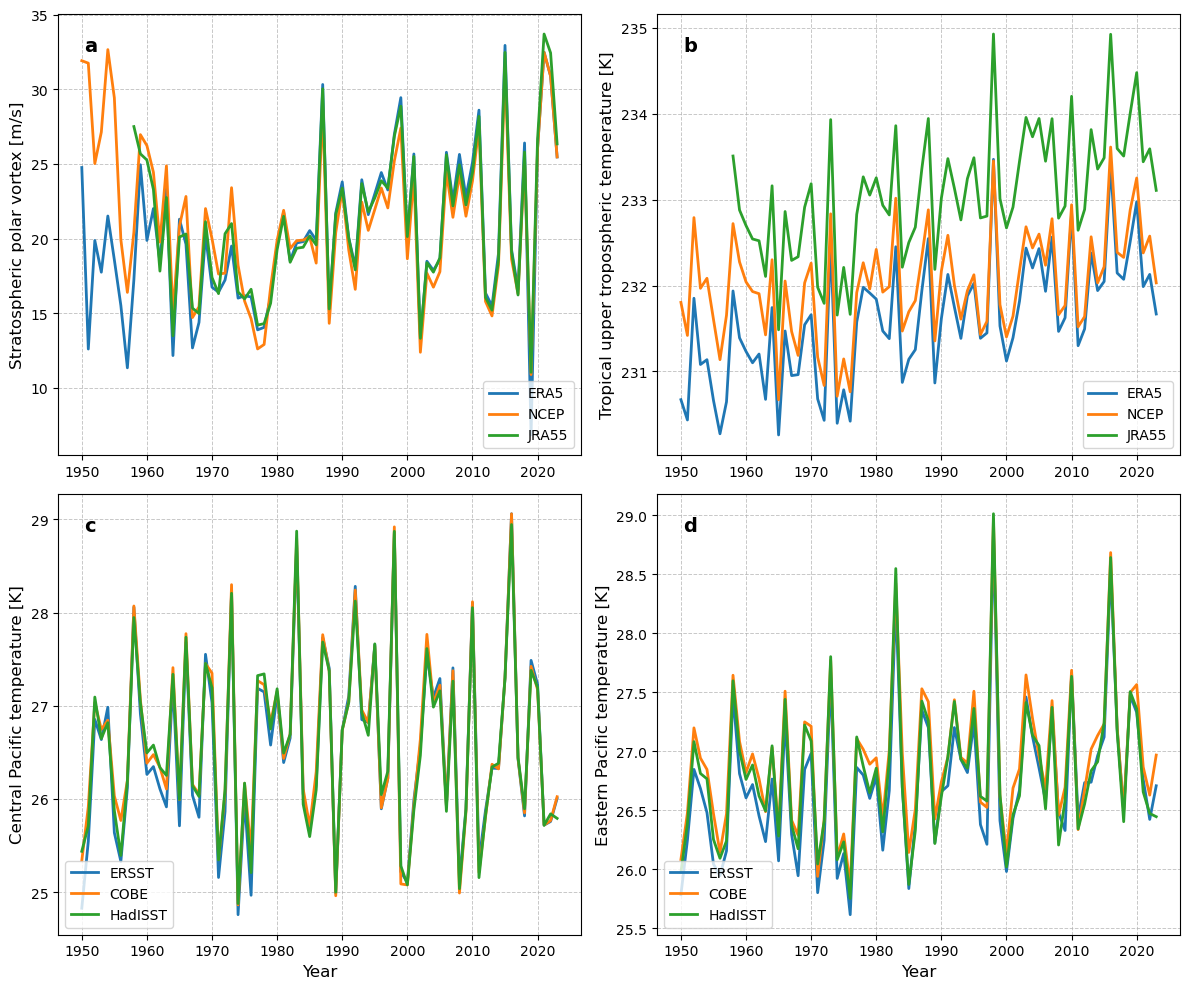

In [23]:

# Set up the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust space between plots
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Labels for subplots
subplot_labels = ['a', 'b', 'c', 'd']
y_labels = [
    'Stratospheric polar vortex [m/s]', 
    'Tropical upper tropospheric temperature [K]', 
    'Central Pacific temperature [K]', 
    'Eastern Pacific temperature [K]'
]

# Colors for the datasets (consistent across subplots)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# First subplot: Plot ERA5, NCEP, JRA55
axes[0, 0].plot(stratospheric_polar_vortex_rean[0].time, stratospheric_polar_vortex_rean[0].values, label="ERA5", color=colors[0], linestyle='-', linewidth=2, markersize=8)
axes[0, 0].plot(stratospheric_polar_vortex_rean[1].time, stratospheric_polar_vortex_rean[1].uwnd.values, label="NCEP", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[0, 0].plot(stratospheric_polar_vortex_rean[2].time, stratospheric_polar_vortex_rean[2].UGRD_GDS4_HYBL_S123.values, label="JRA55", color=colors[2],  linestyle='-', linewidth=2, markersize=8)

# Second subplot: Plot ERA5, NCEP, JRA55
axes[0, 1].plot(tropical_warming[0].time, tropical_warming[0].t.values, label="ERA5", color=colors[0], linestyle='-', linewidth=2, markersize=8)
axes[0, 1].plot(tropical_warming[1].time, tropical_warming[1].air.values, label="NCEP", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[0, 1].plot(tropical_warming[2].time, tropical_warming[2].TMP_GDS4_HYBL_S123.values, label="JRA55", color=colors[2], linestyle='-', linewidth=2, markersize=8)

# Third subplot: Plot ERSST, COBE, HadISST, Kaplan
axes[1, 0].plot(sst_CP_obs[0].sel(time=slice('1950','2023')).time, sst_CP_obs[0].sel(time=slice('1950','2023')).values, label="ERSST", color=colors[0],  linestyle='-', linewidth=2, markersize=8)
axes[1, 0].plot(sst_CP_obs[1].sel(time=slice('1950','2023')).time, sst_CP_obs[1].sel(time=slice('1950','2023')).values, label="COBE", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[1, 0].plot(sst_CP_obs[2].sel(time=slice('1950','2023')).time, sst_CP_obs[2].sel(time=slice('1950','2023')).values, label="HadISST", color=colors[2], linestyle='-', linewidth=2, markersize=8)
#axes[1, 0].plot(sst_CP_obs[3].time, sst_CP_obs[3].values, label="Kaplan", color=colors[3], linestyle='-', linewidth=2, markersize=8)

# Fourth subplot: Plot ERSST, COBE, HadISST, Kaplan
axes[1, 1].plot(sst_EP_obs[0].sel(time=slice('1950','2023')).time, sst_EP_obs[0].sel(time=slice('1950','2023')).values, label="ERSST", color=colors[0], linestyle='-', linewidth=2, markersize=8)
axes[1, 1].plot(sst_EP_obs[1].sel(time=slice('1950','2023')).time, sst_EP_obs[1].sel(time=slice('1950','2023')).values, label="COBE", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[1, 1].plot(sst_EP_obs[2].sel(time=slice('1950','2023')).time, sst_EP_obs[2].sel(time=slice('1950','2023')).values, label="HadISST", color=colors[2],  linestyle='-', linewidth=2, markersize=8)
#axes[1, 1].plot(sst_EP_obs[3].time, sst_EP_obs[3].values, label="Kaplan", color=colors[3], linestyle='-', linewidth=2, markersize=8)

# Add labels and grid to each subplot
for i, ax in enumerate(axes.flat):
    # Set y-axis label
    ax.set_ylabel(y_labels[i], fontsize=12)
    
    # Set x-axis label only for the bottom row
    if i in [2, 3]:  # Bottom subplots
        ax.set_xlabel('Year', fontsize=12)
    
    # Add subplot label in the top left corner of each subplot
    ax.text(0.05, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add grid
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Add legend with custom positions
    if i < 2:  # First two subplots: Bottom-right legend
        ax.legend(loc='lower right', fontsize=10)
    else:  # Last two subplots: Bottom-left legend
        ax.legend(loc='lower left', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


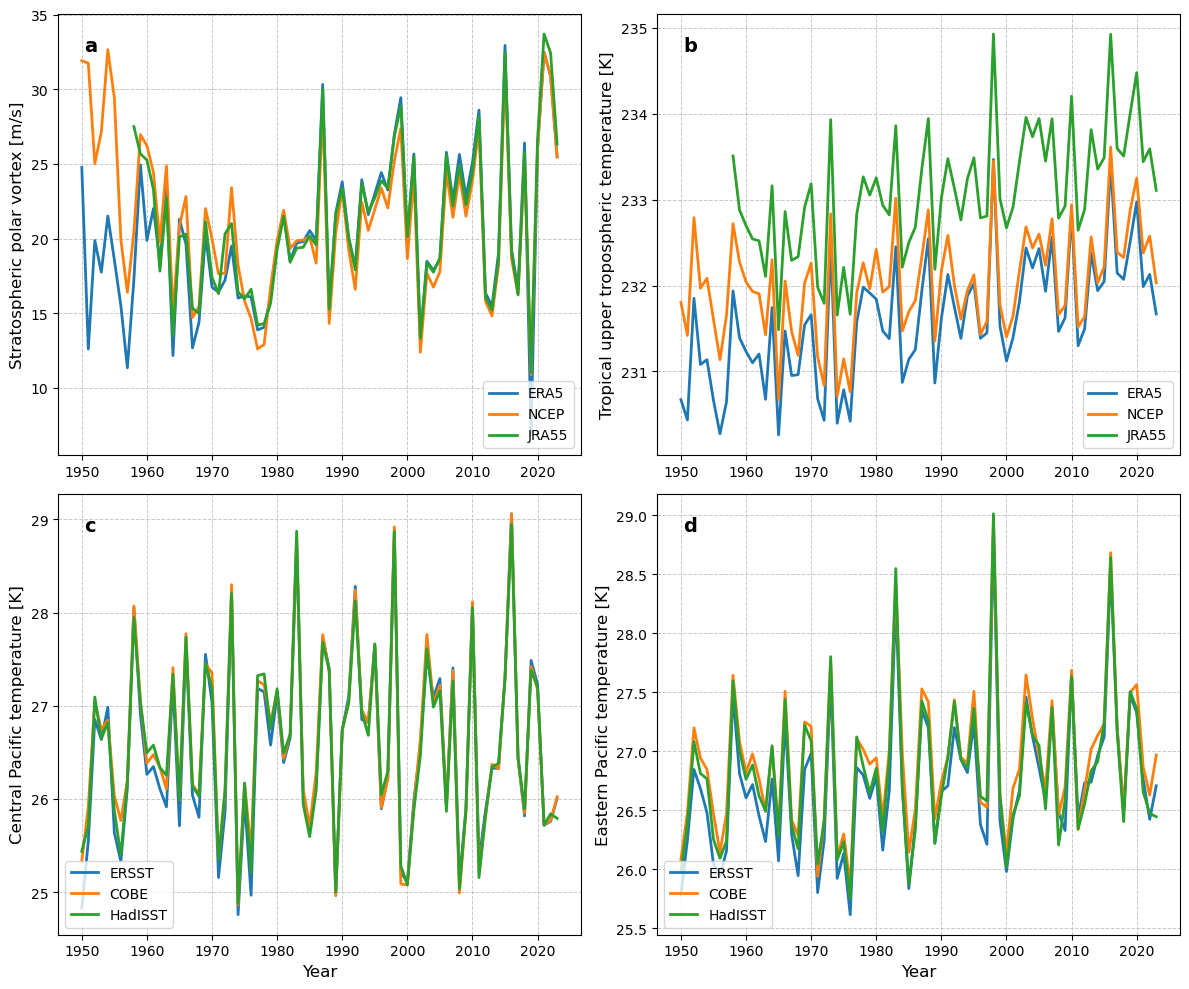

In [12]:

# Set up the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust space between plots
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Labels for subplots
subplot_labels = ['a', 'b', 'c', 'd']
y_labels = [
    'Stratospheric polar vortex [m/s]', 
    'Tropical upper tropospheric temperature [K]', 
    'Central Pacific temperature [K]', 
    'Eastern Pacific temperature [K]'
]

# Colors for the datasets (consistent across subplots)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# First subplot: Plot ERA5, NCEP, JRA55
axes[0, 0].plot(stratospheric_polar_vortex_rean[0].time, stratospheric_polar_vortex_rean[0].values, label="ERA5", color=colors[0], linestyle='-', linewidth=2, markersize=8)
axes[0, 0].plot(stratospheric_polar_vortex_rean[1].time, stratospheric_polar_vortex_rean[1].uwnd.values, label="NCEP", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[0, 0].plot(stratospheric_polar_vortex_rean[2].time, stratospheric_polar_vortex_rean[2].UGRD_GDS4_HYBL_S123.values, label="JRA55", color=colors[2],  linestyle='-', linewidth=2, markersize=8)

# Second subplot: Plot ERA5, NCEP, JRA55
axes[0, 1].plot(tropical_warming[0].time, tropical_warming[0].t.values, label="ERA5", color=colors[0], linestyle='-', linewidth=2, markersize=8)
axes[0, 1].plot(tropical_warming[1].time, tropical_warming[1].air.values, label="NCEP", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[0, 1].plot(tropical_warming[2].time, tropical_warming[2].TMP_GDS4_HYBL_S123.values, label="JRA55", color=colors[2], linestyle='-', linewidth=2, markersize=8)

# Third subplot: Plot ERSST, COBE, HadISST, Kaplan
axes[1, 0].plot(sst_CP_obs[0].sel(time=slice('1950','2023')).time, sst_CP_obs[0].sel(time=slice('1950','2023')).values, label="ERSST", color=colors[0],  linestyle='-', linewidth=2, markersize=8)
axes[1, 0].plot(sst_CP_obs[1].sel(time=slice('1950','2023')).time, sst_CP_obs[1].sel(time=slice('1950','2023')).values, label="COBE", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[1, 0].plot(sst_CP_obs[2].sel(time=slice('1950','2023')).time, sst_CP_obs[2].sel(time=slice('1950','2023')).values, label="HadISST", color=colors[2], linestyle='-', linewidth=2, markersize=8)
#axes[1, 0].plot(sst_CP_obs[3].time, sst_CP_obs[3].values, label="Kaplan", color=colors[3], linestyle='-', linewidth=2, markersize=8)

# Fourth subplot: Plot ERSST, COBE, HadISST, Kaplan
axes[1, 1].plot(sst_EP_obs[0].sel(time=slice('1950','2023')).time, sst_EP_obs[0].sel(time=slice('1950','2023')).values, label="ERSST", color=colors[0], linestyle='-', linewidth=2, markersize=8)
axes[1, 1].plot(sst_EP_obs[1].sel(time=slice('1950','2023')).time, sst_EP_obs[1].sel(time=slice('1950','2023')).values, label="COBE", color=colors[1], linestyle='-', linewidth=2, markersize=8)
axes[1, 1].plot(sst_EP_obs[2].sel(time=slice('1950','2023')).time, sst_EP_obs[2].sel(time=slice('1950','2023')).values, label="HadISST", color=colors[2],  linestyle='-', linewidth=2, markersize=8)
#axes[1, 1].plot(sst_EP_obs[3].time, sst_EP_obs[3].values, label="Kaplan", color=colors[3], linestyle='-', linewidth=2, markersize=8)

# Add labels and grid to each subplot
for i, ax in enumerate(axes.flat):
    # Set y-axis label
    ax.set_ylabel(y_labels[i], fontsize=12)
    
    # Set x-axis label only for the bottom row
    if i in [2, 3]:  # Bottom subplots
        ax.set_xlabel('Year', fontsize=12)
    
    # Add subplot label in the top left corner of each subplot
    ax.text(0.05, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add grid
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Add legend with custom positions
    if i < 2:  # First two subplots: Bottom-right legend
        ax.legend(loc='lower right', fontsize=10)
    else:  # Last two subplots: Bottom-left legend
        ax.legend(loc='lower left', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


#### Trends in EDJ metrics

In [24]:
ua_era5_850_djf = seasonal_data(ua_era5_850,'DJF')
ua_ncep_850_djf = seasonal_data(ua_ncep_850,'DJF')
ua_jra55_850_concat_djf = seasonal_data(ua_jra55_850_concat,'DJF')

In [25]:
era5_lat_Pa, era5_str_Pa = jet_lat_strength(ua_era5_850_djf.u,-140,-70)
ncep_lat_Pa, ncep_str_Pa = jet_lat_strength(ua_ncep_850_djf.uwnd,-140,-70)
jra55_lat_Pa, jra55_str_Pa = jet_lat_strength(ua_jra55_850_concat_djf.UGRD_GDS4_HYBL_S123,-140,-70)
jra55_lat_Pa = jra55_lat_Pa.reshape(-1)
jra55_str_Pa = jra55_str_Pa.reshape(-1)

In [26]:
era5_lat_zm, era5_str_zm = jet_lat_strength(ua_era5_850_djf.u,-180,180)
ncep_lat_zm, ncep_str_zm = jet_lat_strength(ua_ncep_850_djf.uwnd,-180,180)
jra55_lat_zm, jra55_str_zm = jet_lat_strength(ua_jra55_850_concat_djf.UGRD_GDS4_HYBL_S123,-180,180)
jra55_lat_zm = jra55_lat_zm.reshape(-1)
jra55_str_zm = jra55_str_zm.reshape(-1)

In [27]:
era5_lat_A, era5_str_A = jet_lat_strength(ua_era5_850_djf.u,-50,140)
ncep_lat_A, ncep_str_A = jet_lat_strength(ua_ncep_850_djf.uwnd,-50,140)
jra55_lat_A, jra55_str_A = jet_lat_strength(ua_jra55_850_concat_djf.UGRD_GDS4_HYBL_S123,-50,140)
jra55_lat_A = jra55_lat_A.reshape(-1)
jra55_str_A = jra55_str_A.reshape(-1)

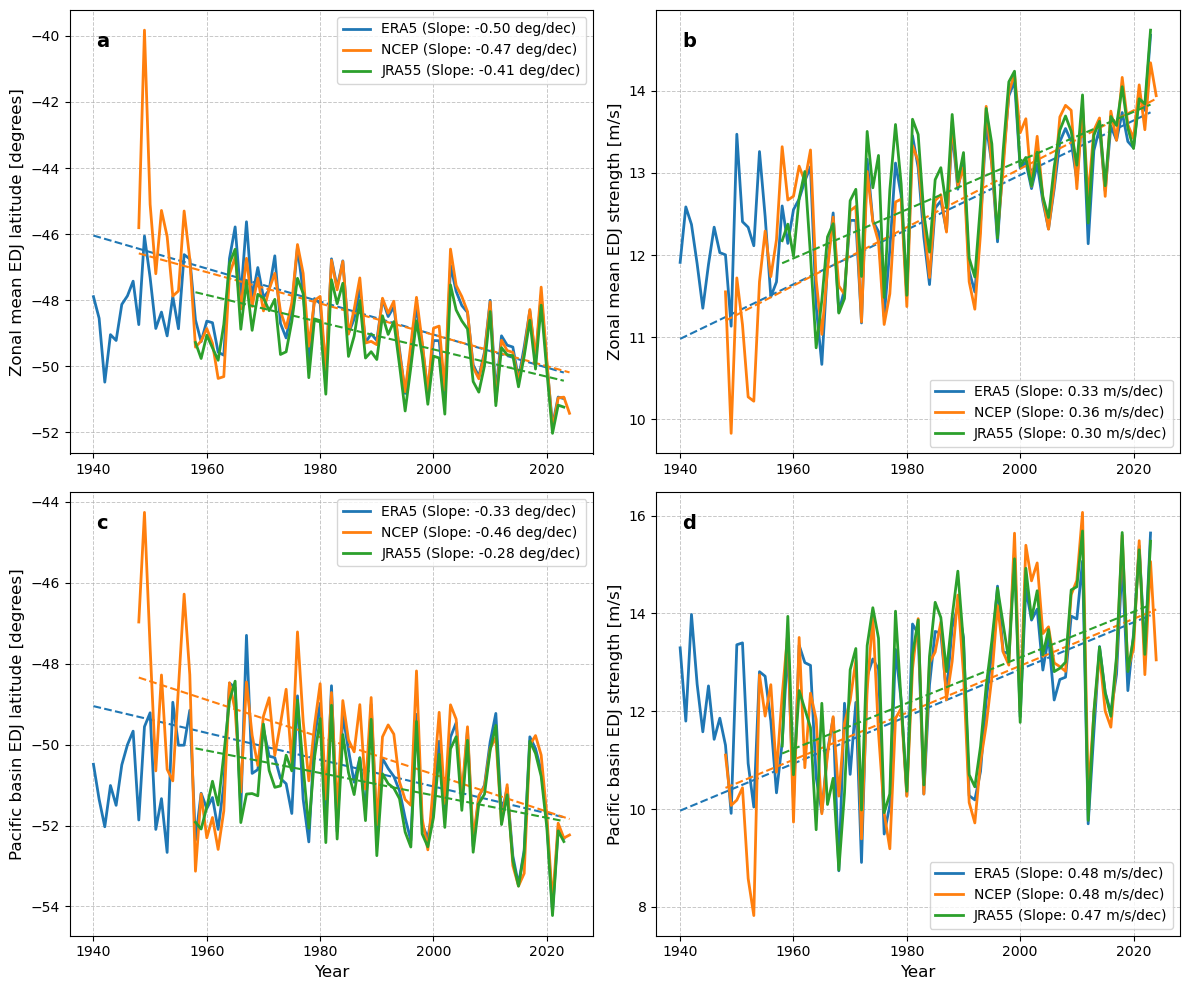

In [20]:

# Set up the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust space between plots
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Labels for subplots
subplot_labels = ['a', 'b', 'c', 'd']
y_labels = [
    'Zonal mean EDJ latitude [degrees]', 
    'Zonal mean EDJ strength [m/s]', 
    'Pacific basin EDJ latitude [degrees]', 
    'Pacific basin EDJ strength [m/s]'
]

# Colors for the datasets (consistent across subplots)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

times = [ua_era5_850_djf.time,ua_ncep_850_djf.time,ua_jra55_850_concat_djf.time]

# First subplot: Plot ERA5, NCEP, JRA55
metric_series = [era5_lat_zm, ncep_lat_zm,jra55_lat_zm]
for series, label, color, years in zip(metric_series, 
                                ["ERA5", "NCEP", "JRA55"], colors[:3],times):
    slope, intercept = linear_regression(years.values[-60:], series[-60:])
    try:
        axes[0, 0].plot(years.values, series, label=f"{label} (Slope: {slope*10:.2f} deg/dec)", color=color,  linestyle='-', linewidth=2, markersize=8)
        axes[0, 0].plot(years.values, intercept + slope * years, color=color, linestyle='--')  # Plot regression line
    except TypeError:
        axes[0, 0].plot(years.values, series, label=f"{label} (Slope: {slope[0]*10:.2f} deg/dec)", color=color,linestyle='-', linewidth=2, markersize=8)
        axes[0, 0].plot(years.values, intercept + slope[0] * years, color=color, linestyle='--')  # Plot regression line

# Second subplot: Plot ERA5, NCEP, JRA55
metric_series = [era5_str_zm, ncep_str_zm,jra55_str_zm]
for series, label, color, years in zip(metric_series, 
                                ["ERA5", "NCEP", "JRA55"], colors[:3],times):
    slope, intercept = linear_regression(years.values[-60:], series[-60:])
    try:
        axes[0, 1].plot(years.values, series, label=f"{label} (Slope: {slope*10:.2f} m/s/dec)", color=color,  linestyle='-', linewidth=2, markersize=8)
        axes[0, 1].plot(years.values, intercept + slope * years, color=color, linestyle='--')  # Plot regression line
    except TypeError:
        axes[0, 1].plot(years.values, series, label=f"{label} (Slope: {slope[0]*10:.2f} m/s/dec)", color=color,linestyle='-', linewidth=2, markersize=8)
        axes[0, 1].plot(years.values, intercept + slope[0] * years, color=color, linestyle='--')  # Plot regression line

# axes[0, 1].plot(times[0],era5_str_zm, label="ERA5", color=colors[0], linestyle='-', linewidth=2, markersize=8)
# axes[0, 1].plot(times[0],ncep_str_zm, label="NCEP", color=colors[1], linestyle='-', linewidth=2, markersize=8)
# axes[0, 1].plot(times[0],jra55_str_zm, label="JRA55", color=colors[2], linestyle='-', linewidth=2, markersize=8)

metric_series = [era5_lat_Pa, ncep_lat_Pa,jra55_lat_Pa]
# Third subplot: Plot ERSST, COBE, HadISST, Kaplan
for series, label, color, years in zip(metric_series, 
                                ["ERA5", "NCEP", "JRA55"], colors[:3],times):
    slope, intercept = linear_regression(years.values[-60:], series[-60:])
    try:
        axes[1, 0].plot(years.values, series, label=f"{label} (Slope: {slope*10:.2f} deg/dec)", color=color,  linestyle='-', linewidth=2, markersize=8)
        axes[1, 0].plot(years.values, intercept + slope * years, color=color, linestyle='--')  # Plot regression line
    except TypeError:
        axes[1, 0].plot(years.values, series, label=f"{label} (Slope: {slope[0]*10:.2f} deg/dec)", color=color,linestyle='-', linewidth=2, markersize=8)
        axes[1, 0].plot(years.values, intercept + slope[0] * years, color=color, linestyle='--')  # Plot regression line

# Fourth subplot: Plot ERSST, COBE, HadISST, Kaplan
metric_series = [era5_str_Pa, ncep_str_Pa,jra55_str_Pa]
for series, label, color, years in zip(metric_series, 
                                ["ERA5", "NCEP", "JRA55"], colors[:3],times):
    slope, intercept = linear_regression(years.values[-60:], series[-60:])
    try:
        axes[1, 1].plot(years.values, series, label=f"{label} (Slope: {slope*10:.2f} m/s/dec)", color=color,  linestyle='-', linewidth=2, markersize=8)
        axes[1, 1].plot(years.values, intercept + slope * years, color=color, linestyle='--')  # Plot regression line
    except TypeError:
        axes[1, 1].plot(years.values, series, label=f"{label} (Slope: {slope[0]*10:.2f} m/s/dec)", color=color,linestyle='-', linewidth=2, markersize=8)
        axes[1, 1].plot(years.values, intercept + slope[0] * years, color=color, linestyle='--')  # Plot regression line


# Add labels and grid to each subplot
for i, ax in enumerate(axes.flat):
    # Set y-axis label
    ax.set_ylabel(y_labels[i], fontsize=12)
    
    # Set x-axis label only for the bottom row
    if i in [2, 3]:  # Bottom subplots
        ax.set_xlabel('Year', fontsize=12)
    
    # Add subplot label in the top left corner of each subplot
    ax.text(0.05, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add grid
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Add legend with custom positions
    if i in [0,2]:  # First two subplots: Bottom-right legend
        ax.legend(loc='upper right', fontsize=10)
    else:  # Last two subplots: Bottom-left legend
        ax.legend(loc='lower right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [21]:
u850_CN_coefs_NCEP_detrend = xr.open_dataset('/home/jmindlin/causal_EDJ/exploring_ideas/u/regression_coefficients_ncep_withGMST.nc')
ua_NCEP_djf_clim = ua_ncep_850.sel(time=slice('1950','1979')).mean(dim='time').uwnd
ua_NCEP_djf_std = ua_ncep_850.sel(time=slice('1950','2023')).std(dim='time').uwnd
reconstruction_NCEP_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_NCEP_detrend.tw*std_anom(tropical_warming[1].air.sel(time=slice('1950','2023')))*ua_NCEP_djf_std + u850_CN_coefs_NCEP_detrend.spv*std_anom(stratospheric_polar_vortex_rean[1].uwnd.sel(time=slice('1950','2023')))*ua_NCEP_djf_std  + u850_CN_coefs_NCEP_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std + u850_CN_coefs_NCEP_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std  + u850_CN_coefs_NCEP_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_NCEP_djf_std
recon_lat_NCEP, recon_str_NCEP = jet_lat_strength(reconstruction_NCEP_withGW,-180,180)
recon_lat_P_NCEP, recon_str_P_NCEP = jet_lat_strength(reconstruction_NCEP_withGW,-140,-70)
recon_lat_A_NCEP, recon_str_A_NCEP = jet_lat_strength(reconstruction_NCEP_withGW,-50,140)
time_obs = tas_DJF.sel(time=slice('1950','2023')).time

In [29]:
# trend_dict_lat = {}
# trend_dict_str = {}
# trend_dict_lat_P = {}
# trend_dict_str_P = {}
# trend_dict_lat_A = {}
# trend_dict_str_A = {}

# TW_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_NCEP_detrend.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_tw, recon_str_tw = jet_lat_strength(TW_picontrol_withGW,-50,140)
# slopea, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_tw)
# trend_dict_lat_A['TW'] = slopea*10
# slopeb, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_tw)
# trend_dict_str_A['TW'] = slopeb*10

# SPV_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_NCEP_detrend.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std  
# recon_lat_spv, recon_str_spv = jet_lat_strength(SPV_picontrol_withGW,-50,140)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_spv)
# trend_dict_lat_A['SPV'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_spv)
# trend_dict_str_A['SPV'] = slope*10

# CP_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) +u850_CN_coefs_NCEP_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_cp, recon_str_cp = jet_lat_strength(CP_picontrol_withGW,-50,140)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_cp)
# trend_dict_lat_A['CP'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_cp)
# trend_dict_str_A['CP'] = slope*10

# EP_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_NCEP_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_ep, recon_str_ep = jet_lat_strength(EP_picontrol_withGW,-50,140)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_ep)
# trend_dict_lat_A['EP'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_ep)
# trend_dict_str_A['EP'] = slope*10

# GW_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_NCEP_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_NCEP_djf_std
# recon_lat_gw, recon_str_gw = jet_lat_strength(GW_picontrol_withGW,-50,140)
# slope, intercept = linear_regression(time_obs.values, recon_lat_gw)
# trend_dict_lat_A['GW'] = slope*10
# slope, intercept = linear_regression(time_obs.values, recon_str_gw)
# trend_dict_str_A['GW'] = slope*10

# trend_dict_lat_A['ALL RDs'] = trend_dict_lat_A['TW'] + trend_dict_lat_A['GW'] + trend_dict_lat_A['EP'] + trend_dict_lat_A['CP'] + trend_dict_lat_A['SPV'] 
# trend_dict_str_A['ALL RDs'] = trend_dict_str_A['TW'] + trend_dict_str_A['GW'] + trend_dict_str_A['EP'] + trend_dict_str_A['CP'] + trend_dict_str_A['SPV'] 

# TW_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_NCEP_detrend.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_tw, recon_str_tw = jet_lat_strength(TW_picontrol_withGW,-180,180)
# slopea, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_tw)
# trend_dict_lat['TW'] = slopea*10
# slopeb, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_tw)
# trend_dict_str['TW'] = slopeb*10

# SPV_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_NCEP_detrend.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std  
# recon_lat_spv, recon_str_spv = jet_lat_strength(SPV_picontrol_withGW,-180,180)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_spv)
# trend_dict_lat['SPV'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_spv)
# trend_dict_str['SPV'] = slope*10

# CP_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) +u850_CN_coefs_NCEP_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_cp, recon_str_cp = jet_lat_strength(CP_picontrol_withGW,-180,180)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_cp)
# trend_dict_lat['CP'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_cp)
# trend_dict_str['CP'] = slope*10

# EP_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_NCEP_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_ep, recon_str_ep = jet_lat_strength(EP_picontrol_withGW,-180,180)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_ep)
# trend_dict_lat['EP'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_ep)
# trend_dict_str['EP'] = slope*10

# GW_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_NCEP_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_NCEP_djf_std
# recon_lat_gw, recon_str_gw = jet_lat_strength(GW_picontrol_withGW,-180,180)
# slope, intercept = linear_regression(time_obs.values, recon_lat_gw)
# trend_dict_lat['GW'] = slope*10
# slope, intercept = linear_regression(time_obs.values, recon_str_gw)
# trend_dict_str['GW'] = slope*10

# trend_dict_lat['ALL RDs'] = trend_dict_lat['TW'] + trend_dict_lat['GW'] + trend_dict_lat['EP'] + trend_dict_lat['CP'] + trend_dict_lat['SPV'] 
# trend_dict_str['ALL RDs'] = trend_dict_str['TW'] + trend_dict_str['GW'] + trend_dict_str['EP'] + trend_dict_str['CP'] + trend_dict_str['SPV'] 

# TW_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_NCEP_detrend.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_tw, recon_str_tw = jet_lat_strength(TW_picontrol_withGW,-140,-70)
# slopea, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_tw)
# trend_dict_lat_P['TW'] = slopea*10
# slopeb, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_tw)
# trend_dict_str_P['TW'] = slopeb*10

# SPV_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_NCEP_detrend.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std  
# recon_lat_spv, recon_str_spv = jet_lat_strength(SPV_picontrol_withGW,-140,-70)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_spv)
# trend_dict_lat_P['SPV'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_spv)
# trend_dict_str_P['SPV'] = slope*10

# CP_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) +u850_CN_coefs_NCEP_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_cp, recon_str_cp = jet_lat_strength(CP_picontrol_withGW,-140,-70)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_cp)
# trend_dict_lat_P['CP'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_cp)
# trend_dict_str_P['CP'] = slope*10

# EP_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_NCEP_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_NCEP_djf_std 
# recon_lat_ep, recon_str_ep = jet_lat_strength(EP_picontrol_withGW,-140,-70)
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_ep)
# trend_dict_lat_P['EP'] = slope*10
# slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_ep)
# trend_dict_str_P['EP'] = slope*10

# GW_picontrol_withGW =  ua_NCEP_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_NCEP_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_NCEP_djf_std
# recon_lat_gw, recon_str_gw = jet_lat_strength(GW_picontrol_withGW,-140,-70)
# slope, intercept = linear_regression(time_obs.values, recon_lat_gw)
# trend_dict_lat_P['GW'] = slope*10
# slope, intercept = linear_regression(time_obs.values, recon_str_gw)
# trend_dict_str_P['GW'] = slope*10

# trend_dict_lat_P['ALL RDs'] = trend_dict_lat_P['TW'] + trend_dict_lat_P['GW'] + trend_dict_lat_P['EP'] + trend_dict_lat_P['CP'] + trend_dict_lat_P['SPV'] 
# trend_dict_str_P['ALL RDs'] = trend_dict_str_P['TW'] + trend_dict_str_P['GW'] + trend_dict_str_P['EP'] + trend_dict_str_P['CP'] + trend_dict_str_P['SPV'] 

### EDJ reconstruction ERA5

In [30]:
ua_era5_model_grid = seasonal_data(xr.open_dataset(path+'/ERA5/ua_ERA5_model_grid.nc').sel(level=850).u,'DJF')

In [32]:
# reconstruction with ERA5 patterns - detrended 
ua_era5_djf_clim = ua_era5_model_grid.sel(time=slice('1950','1979')).mean(dim='time')
ua_era5_djf_std = ua_era5_model_grid.sel(time=slice('1950','2023')).std(dim='time')
u850_CN_coefs_ERA5_detrend = xr.open_dataset(path+'/u850/regression_coefficients_era5_T42.nc')
reconstruction_era5_withGW =  ua_era5_djf_clim*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_era5_djf_std + u850_CN_coefs_ERA5_detrend.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_era5_djf_std  + u850_CN_coefs_ERA5_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std + u850_CN_coefs_ERA5_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std  + u850_CN_coefs_ERA5_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_era5_djf_std
recon_lat_era5, recon_str_era5 = jet_lat_strength_model(reconstruction_era5_withGW,-180,180)
recon_lat_P_era5, recon_str_P_era5 = jet_lat_strength_model(reconstruction_era5_withGW,-140,-70)
recon_lat_A_era5, recon_str_A_era5 = jet_lat_strength_model(reconstruction_era5_withGW,-50,140)
time_obs = tas_DJF.sel(time=slice('1950','2023')).time

In [33]:
trend_dict_lat = {}
trend_dict_str = {}
trend_dict_lat_P = {}
trend_dict_str_P = {}
trend_dict_lat_A = {}
trend_dict_str_A = {}

TW_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_tw, recon_str_tw = jet_lat_strength_model(TW_picontrol_withGW,-50,140)
slopea, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_tw)
trend_dict_lat_A['TW'] = slopea*10
slopeb, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_tw)
trend_dict_str_A['TW'] = slopeb*10

SPV_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_ERA5_detrend.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_era5_djf_std  
recon_lat_spv, recon_str_spv = jet_lat_strength_model(SPV_picontrol_withGW,-50,140)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_spv)
trend_dict_lat_A['SPV'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_spv)
trend_dict_str_A['SPV'] = slope*10

CP_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) +u850_CN_coefs_ERA5_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_cp, recon_str_cp = jet_lat_strength_model(CP_picontrol_withGW,-50,140)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_cp)
trend_dict_lat_A['CP'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_cp)
trend_dict_str_A['CP'] = slope*10

EP_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_ep, recon_str_ep = jet_lat_strength_model(EP_picontrol_withGW,-50,140)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_ep)
trend_dict_lat_A['EP'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_ep)
trend_dict_str_A['EP'] = slope*10

GW_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_ERA5_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_era5_djf_std
recon_lat_gw, recon_str_gw = jet_lat_strength_model(GW_picontrol_withGW,-50,140)
slope, intercept = linear_regression(time_obs.values, recon_lat_gw)
trend_dict_lat_A['GW'] = slope*10
slope, intercept = linear_regression(time_obs.values, recon_str_gw)
trend_dict_str_A['GW'] = slope*10

trend_dict_lat_A['ALL RDs'] = trend_dict_lat_A['TW'] + trend_dict_lat_A['GW'] + trend_dict_lat_A['EP'] + trend_dict_lat_A['CP'] + trend_dict_lat_A['SPV'] 
trend_dict_str_A['ALL RDs'] = trend_dict_str_A['TW'] + trend_dict_str_A['GW'] + trend_dict_str_A['EP'] + trend_dict_str_A['CP'] + trend_dict_str_A['SPV'] 

TW_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_tw, recon_str_tw = jet_lat_strength_model(TW_picontrol_withGW,-180,180)
slopea, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_tw)
trend_dict_lat['TW'] = slopea*10
slopeb, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_tw)
trend_dict_str['TW'] = slopeb*10

SPV_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_ERA5_detrend.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_era5_djf_std  
recon_lat_spv, recon_str_spv = jet_lat_strength_model(SPV_picontrol_withGW,-180,180)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_spv)
trend_dict_lat['SPV'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_spv)
trend_dict_str['SPV'] = slope*10

CP_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) +u850_CN_coefs_ERA5_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_cp, recon_str_cp = jet_lat_strength_model(CP_picontrol_withGW,-180,180)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_cp)
trend_dict_lat['CP'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_cp)
trend_dict_str['CP'] = slope*10

EP_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_ep, recon_str_ep = jet_lat_strength_model(EP_picontrol_withGW,-180,180)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_ep)
trend_dict_lat['EP'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_ep)
trend_dict_str['EP'] = slope*10

GW_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_ERA5_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_era5_djf_std
recon_lat_gw, recon_str_gw = jet_lat_strength_model(GW_picontrol_withGW,-180,180)
slope, intercept = linear_regression(time_obs.values, recon_lat_gw)
trend_dict_lat['GW'] = slope*10
slope, intercept = linear_regression(time_obs.values, recon_str_gw)
trend_dict_str['GW'] = slope*10

trend_dict_lat['ALL RDs'] = trend_dict_lat['TW'] + trend_dict_lat['GW'] + trend_dict_lat['EP'] + trend_dict_lat['CP'] + trend_dict_lat['SPV'] 
trend_dict_str['ALL RDs'] = trend_dict_str['TW'] + trend_dict_str['GW'] + trend_dict_str['EP'] + trend_dict_str['CP'] + trend_dict_str['SPV'] 

TW_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_tw, recon_str_tw = jet_lat_strength_model(TW_picontrol_withGW,-140,-70)
slopea, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_tw)
trend_dict_lat_P['TW'] = slopea*10
slopeb, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_tw)
trend_dict_str_P['TW'] = slopeb*10

SPV_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_ERA5_detrend.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_era5_djf_std  
recon_lat_spv, recon_str_spv = jet_lat_strength_model(SPV_picontrol_withGW,-140,-70)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_spv)
trend_dict_lat_P['SPV'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_spv)
trend_dict_str_P['SPV'] = slope*10

CP_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) +u850_CN_coefs_ERA5_detrend.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_cp, recon_str_cp = jet_lat_strength_model(CP_picontrol_withGW,-140,-70)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_cp)
trend_dict_lat_P['CP'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_cp)
trend_dict_str_P['CP'] = slope*10

EP_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std 
recon_lat_ep, recon_str_ep = jet_lat_strength_model(EP_picontrol_withGW,-140,-70)
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_lat_ep)
trend_dict_lat_P['EP'] = slope*10
slope, intercept = linear_regression(tas_DJF.sel(time=slice('1950','2023')).time.values, recon_str_ep)
trend_dict_str_P['EP'] = slope*10

GW_picontrol_withGW =  ua_era5_model_grid.mean(dim='time')*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023')))  + u850_CN_coefs_ERA5_detrend.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_era5_djf_std
recon_lat_gw, recon_str_gw = jet_lat_strength_model(GW_picontrol_withGW,-140,-70)
slope, intercept = linear_regression(time_obs.values, recon_lat_gw)
trend_dict_lat_P['GW'] = slope*10
slope, intercept = linear_regression(time_obs.values, recon_str_gw)
trend_dict_str_P['GW'] = slope*10

trend_dict_lat_P['ALL RDs'] = trend_dict_lat_P['TW'] + trend_dict_lat_P['GW'] + trend_dict_lat_P['EP'] + trend_dict_lat_P['CP'] + trend_dict_lat_P['SPV'] 
trend_dict_str_P['ALL RDs'] = trend_dict_str_P['TW'] + trend_dict_str_P['GW'] + trend_dict_str_P['EP'] + trend_dict_str_P['CP'] + trend_dict_str_P['SPV'] 

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:107: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:107: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\m'
/var/folders/50/49j6_slj4k9bq1x354fp5jwh0000gn/T/ipykernel_84227/2693305778.py:8: SyntaxWarning: invalid escape sequence '\m'
  '$\mathbf{Zonal mean}$ \n latitude [degrees]',
/var/folders/50/49j6_slj4k9bq1x354fp5jwh0000gn/T/ipykernel_84227/2693305778.py:10: SyntaxWarning: invalid escape sequence '\m'
  '$\mathbf{Pacific}$ \n latitude [degrees]',
/var/folders/50/49j6_slj4k9bq1x354fp5jwh0000gn/T/ipykernel_84227/2693305778.py:12: SyntaxWarning: invalid escape sequence '\m'
  '$\mathbf{A

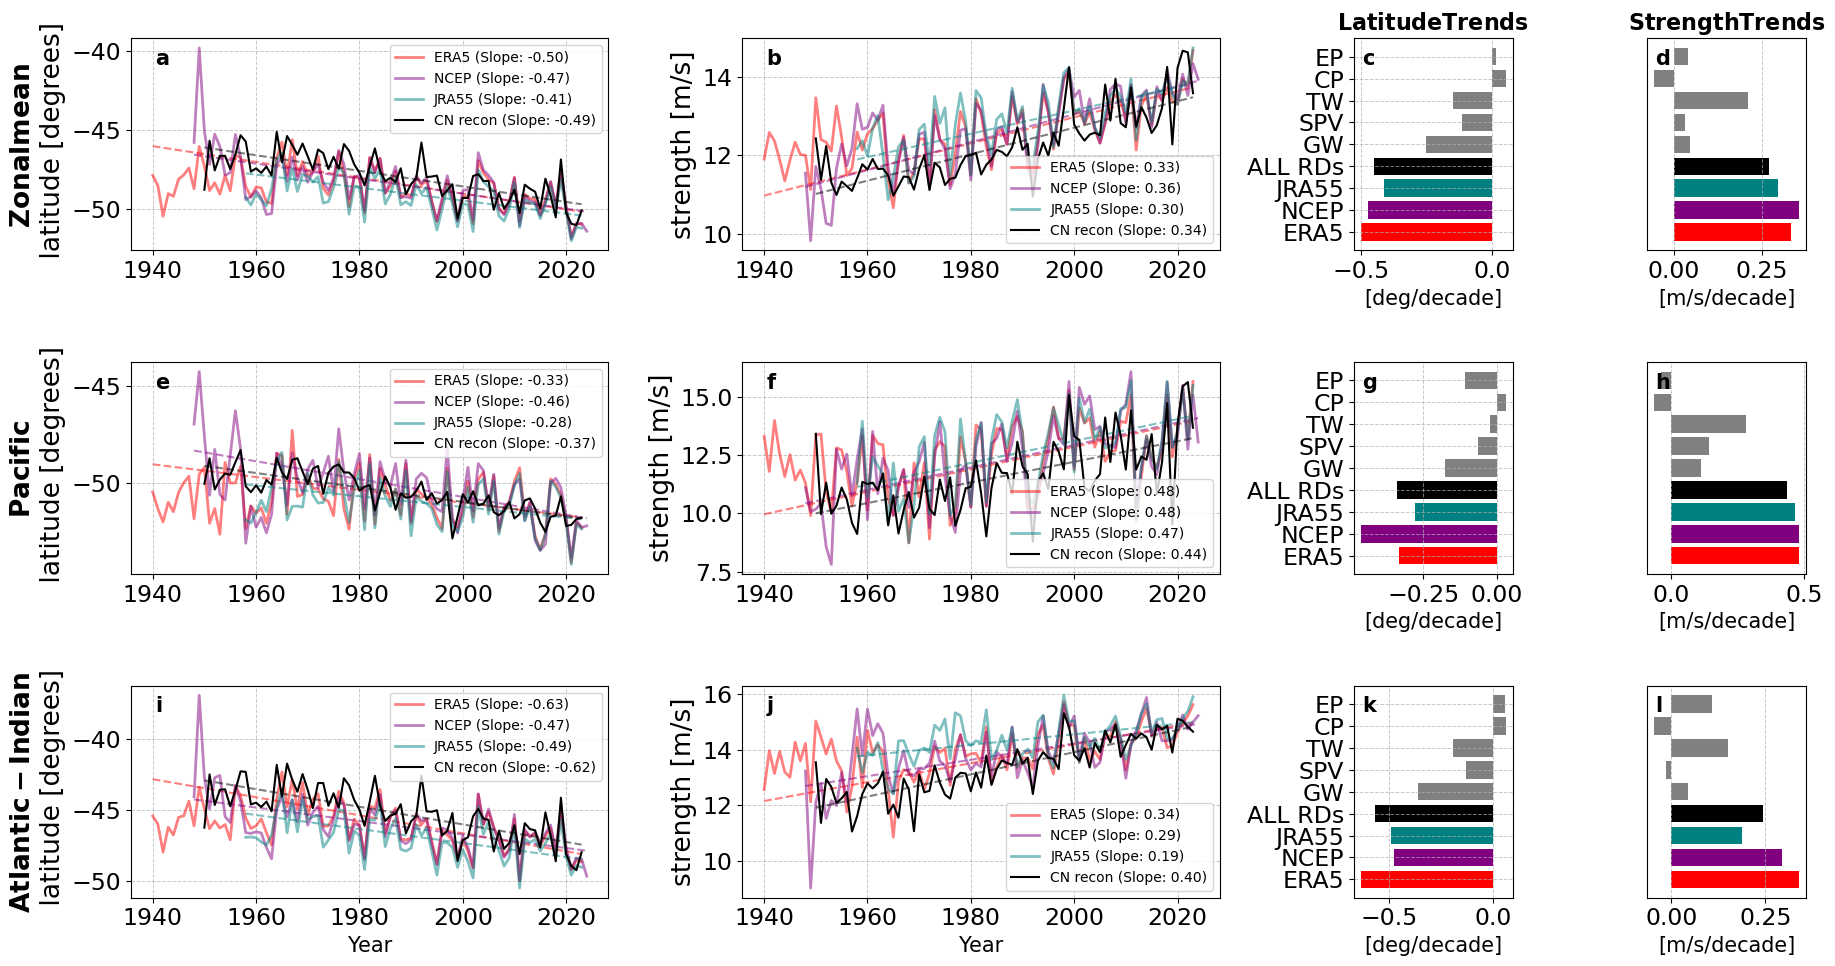

In [104]:

# Define figure and gridspec layout
fig = plt.figure(figsize=(20, 10),dpi=100)
gs = gridspec.GridSpec(3, 5, width_ratios=[3, 3, 1, 1, 0.1])  # Make the line plots wider (ratios 3) and bar plots narrower (ratios 1)

# Labels for subplots
subplot_labels = ['a', 'b', 'e', 'f', 'i', 'j']
y_labels = [
    '$\mathbf{Zonal mean}$ \n latitude [degrees]', 
    'strength [m/s]', 
    '$\mathbf{Pacific}$ \n latitude [degrees]', 
    'strength [m/s]',
    '$\mathbf{Atlantic-Indian}$ \n latitude [degrees]', 
    'strength [m/s]'
]

# Colors for the datasets
colors = ['red', 'purple', 'teal']
times = [ua_era5_850_djf.time, ua_ncep_850_djf.time, ua_jra55_850_concat_djf.time]
time_obs = reconstruction_era5_withGW.time

# Line plot data
metric_series_list = [
    [era5_lat_zm, ncep_lat_zm, jra55_lat_zm], [era5_str_zm, ncep_str_zm, jra55_str_zm], 
    [era5_lat_Pa, ncep_lat_Pa, jra55_lat_Pa], [era5_str_Pa, ncep_str_Pa, jra55_str_Pa], 
    [era5_lat_A, ncep_lat_A, jra55_lat_A], [era5_str_A, ncep_str_A, jra55_str_A]
]

recon_series_list = [
    recon_lat_era5, recon_str_era5, 
    recon_lat_P_era5, recon_str_P_era5, 
    recon_lat_A_era5, recon_str_A_era5
]

trend_dicts = [trend_dict_lat, trend_dict_str, trend_dict_lat_P, trend_dict_str_P, trend_dict_lat_A, trend_dict_str_A]

# Line plots
for i in range(6):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    metric_series = metric_series_list[i]
    recon_series = recon_series_list[i]
    trend_dict = trend_dicts[i]
    
    for series, label, color, years in zip(metric_series, ["ERA5", "NCEP", "JRA55"], colors, times):
        slope, intercept = linear_regression(years.values[-60:], series[-60:])
        slope = slope[0] if isinstance(slope, np.ndarray) else slope
        trend_dict[label] = slope * 10
        
        ax.plot(years.values, series, label=f"{label} (Slope: {slope*10:.2f})", color=color, linestyle='-', linewidth=2, alpha=0.5)
        ax.plot(years.values, intercept + slope * years, color=color, linestyle='--', alpha=0.5)
    
    # Plot the reconstruction line
    slope, intercept = linear_regression(time_obs.values, recon_series)
    ax.plot(time_obs.values, recon_series, label=f"CN recon (Slope: {slope*10:.2f})", color='k')
    ax.plot(time_obs.values, intercept + slope * time_obs.values, color='k', linestyle='--', alpha=0.5)

    ax.set_ylabel(y_labels[i], fontsize=19)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Set legend position based on column index
    if i % 2 == 1:  # For subplots in the second column (index 1)
        ax.legend(loc='lower right', fontsize=10)
    else:  # For subplots in the first column (index 0)
        ax.legend(loc='upper right', fontsize=10)

    if i in [4,5]:  # For subplots in the second column (index 1)
        ax.set_xlabel('Year', fontsize=15)
    
    ax.text(0.05, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    ax.tick_params(axis='both', which='major', labelsize=17)

# Bar plot helper function
def plot_bar_subplot(ax, data_dict, title, units='[units/yr]',yticks='yes',subplot_label='a'):
    labels = [key for key in order if key in colors_dict]
    values = [data_dict[key] for key in labels]
    colors = [colors_dict[key] for key in labels]
    
    ax.barh(labels, values, color=colors)
    ax.set_xlabel(units, fontsize=15)
    ax.set_title(title, fontsize=16)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    ax.text(0.05, 0.95, subplot_label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    ax.tick_params(axis='both', which='major', labelsize=17)

    if yticks == 'no':
        ax.set_yticks([])
        ax.set_yticklabels([])


# Define colors for the bar plots
colors_dict = {
    'ERA5': 'red',
    'NCEP': 'purple',
    'JRA55': 'teal',
    'ALL RDs': 'black',
    'GW': 'grey',
    'SPV': 'grey',
    'TW': 'grey',
    'CP': 'grey',
    'EP': 'grey',
}

# Define order for the bar plots
order = ['ERA5', 'NCEP', 'JRA55', 'ALL RDs', 'GW', 'SPV', 'TW', 'CP', 'EP']


# Bar plots
plot_bar_subplot(fig.add_subplot(gs[0, 2]), trend_dict_lat, '$\mathbf{Latitude Trends}$', units='[deg/decade]',subplot_label='c')
plot_bar_subplot(fig.add_subplot(gs[0, 3]), trend_dict_str, '$\mathbf{Strength Trends}$', units='[m/s/decade]',yticks='no',subplot_label='d')
plot_bar_subplot(fig.add_subplot(gs[1, 2]), trend_dict_lat_P, ' ', units='[deg/decade]',subplot_label='g')
plot_bar_subplot(fig.add_subplot(gs[1, 3]), trend_dict_str_P, ' ', units='[m/s/decade]',yticks='no',subplot_label='h')
plot_bar_subplot(fig.add_subplot(gs[2, 2]), trend_dict_lat_A, ' ', units='[deg/decade]',subplot_label='k')
plot_bar_subplot(fig.add_subplot(gs[2, 3]), trend_dict_str_A, ' ', units='[m/s/decade]',yticks='no',subplot_label='l')

# Show the final plot
plt.tight_layout()
plt.show()
